# First exposure calculations

To do:
- fix up paths of demogrpahics4climate so it can be run from anywhere, automate its running for any given year... / separately run and save output for the years I need - ok now?
- currently population is 2020 but warming level is "present-day" from Forster 2023(?) paper, so I should get population for 2022 - DONE, ok now 

Next steps:

- clean this up ! 
- can calculate this for every year/warming level ! & do a spaghetti plot of each model 
- now do observations and decide how to merge models and obs, might need to fit to distribution in models also & how to do model eval
- decide whether to use a different metric (3dTX90) and if so what distribution it can be fitted to 




In [1]:
# necessary: netcdf4-python, regionmask (automatically imports xarray),opnepyxl, Cartopy
# check if I can automate this 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
%matplotlib inline
import os, glob, re, sys
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import netCDF4

from settings import *
start_message()

from functions import * # move fxns here when good ! rename this ! 

sys.path.append('../population/')
from population_demographics_climate import * # move / rename this when good ! 

/apps/brussel/RL8/broadwell/software/Python/3.10.4-GCCcore-11.3.0/lib/python3.10/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


settings loaded
flags {'models': 'ISIMIP3b', 'metric': 'TX95', 'method': 'percentile', 'var': 'tasmax'} 
indirs: [' ', ' ', ' '] 
GCMs: ['none'] 
obs datasets: ['none'] 
lat chunk: 90 
lon chunk: 120 
time chunk: -1 
outdirs: /data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output 
figdirs: /data/brussel/vo/000/bvo00012/vsc10419/attr-hw/figures 
start_pi: 1850 
end_pi: 1900


In [2]:
os.getcwd()

'/vscmnt/brussel_pixiu_data/_data_brussel/vo/000/bvo00012/vsc10419/attr-hw/attr-hw-scripts/isimip3b-TX99'

## 1. load population data for 2022

next step: make more flexible the filepaths to data so you can run fxns from here

In [3]:
sys.path.append('../population/') # make this a module i can pip install and import ! 
from population_demographics_climate import * # move / rename this when good ! 


In [4]:
d_countries = preprocess_all_country_population_data()
gs_population_global = get_gridscale_population_global( 
    d_countries,
    startyear=2022,
    endyear=None,
    save=False # change where this gets saved !!!! now its in package folder
)

interpolating cohort sizes per country
after interpolation and mean-preserving correction there are some neg numbers in 10, Azerbaijan, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 98, Libya, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 136, Papua New Guinea, setting them to zero
Aruba small, population not calculated
Antigua and Barbuda small, population not calculated
Bahrain small, population not calculated
Barbados small, population not calculated
Federated States of Micronesia small, population not calculated
Grenada small, population not calculated
Guam small, population not calculated
Saint Lucia small, population not calculated
Macao small, population not calculated
Maldives small, population not calculated
Malta small, population not calculated
Singapore small, population not calculated
Tonga small, population not calculated
calculating gridscale population per cou

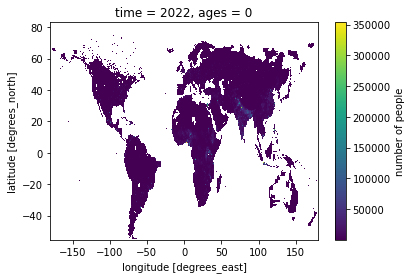

In [5]:
gs_population_global.sel(ages=0).where(gs_population_global.sel(ages=0)!=0).plot()

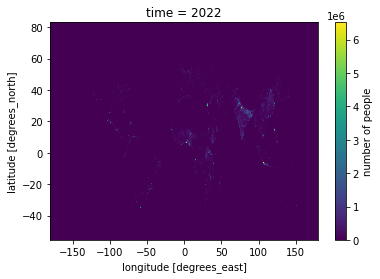

In [6]:
gs_n_children = gs_population_global.sel(ages=slice(0,18)).sum(dim='ages') 
gs_n_children.plot()

## 2. calculate number of attributable events in present-day warming (2022 levels)

Note. can automate main.py script to do this for any year

In [7]:
GCM = GCMs[0]
print(GCM)
# sort out the getoutputpaths function its doing weird shit ! 

datadir = f'/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_sep23-8523898/TX99/ISIMIP3b/{GCM}'

p_pi = 1-0.99 # probability of ocurrence in pre-industrial 
data_pi_99 = xr.open_dataarray( glob.glob(os.path.join(datadir,  '{}*1850_1900.nc'.format(GCM.lower())) )[0], engine='netcdf4')
percentiles_pres_da = xr.open_dataarray(glob.glob(os.path.join(datadir, '{}*percentiles_pres_piTX99*.nc'.format(GCM.lower())))[0])

CanESM5


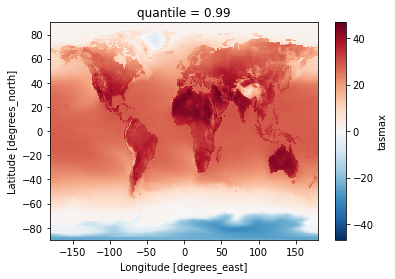

In [8]:
(data_pi_99-273.15).plot() # what temperature corresponds to TX99 in pre-industrial 

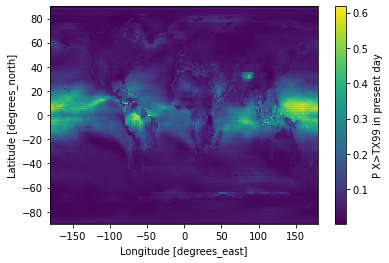

In [9]:
p_pd = 1-percentiles_pres_da
(1-percentiles_pres_da).plot(cbar_kwargs={'label': 'P X>TX99 in present day'}) # probability of exceedance in present day

# remove "long name" drop it ! 

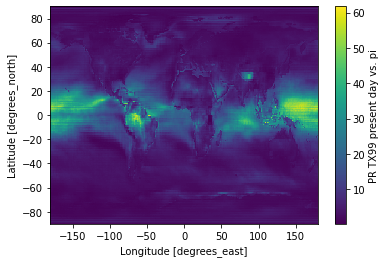

In [10]:
(p_pd / p_pi).plot(cbar_kwargs={'label': 'PR TX99 present day vs. pi'}) # PR- - Probability ratio

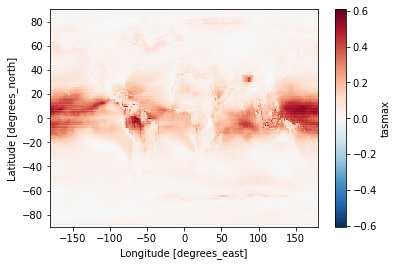

In [11]:
(p_pd - p_pi).plot() # change in probability 

Text(0.5, 1.0, 'number of attributable hot days in 2020')

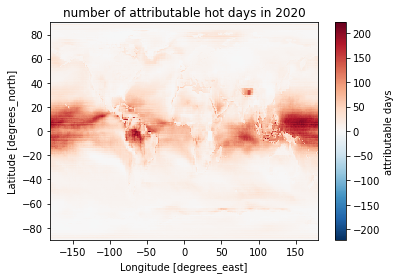

In [14]:
# number of attributable events (days) = ndays * (p_pd - p_pi)

# example: number of attributable days in 2020 (or present day warming whatever year it is check !!)

n_attr_2022 = 365 * (p_pd - p_pi)
n_attr_2022.plot(cbar_kwargs={'label': 'attributable days'})

plt.title('number of attributable hot days in 2020')

In [15]:
n_attr_2022.where(n_attr_2020>0).sum()

# a total of 6.3 milion attributable hot days over the whole globe, including ocean 

<xarray.DataArray 'tasmax' ()>
array(6286889., dtype=float32)

## 3. combine climate and population data

Text(0.5, 1.0, 'number of children x number of attributable hot days \nin 2020')

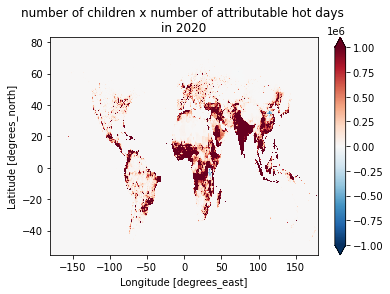

In [16]:
# people x events

children_hw_2022 = gs_n_children * n_attr_2022
children_hw_2022.plot(vmax=1e6)

plt.title('number of children x number of attributable hot days \nin 2020')


In [17]:
children_hw_2022.sum()

<xarray.DataArray ()>
array(4.22436995e+10)

In [19]:
children_hw_2022.where(children_hw_2022>0).sum()

# in places where the model shows an increase in heatwaves, children x heatwaves = 42 billion attributable hot days 


<xarray.DataArray ()>
array(4.23028613e+10)

In [20]:
children_hw_2022.where(children_hw_2022<0).sum() 

# according to this model, decrease in 58 million children x heatwaves 

<xarray.DataArray ()>
array(-59161768.74966363)

In [21]:
gs_n_children.where(n_attr_2022>0).sum() # 2.2 bilion children live in places where heatwaves have increased

<xarray.DataArray 'number of people' ()>
array(2.21204534e+09)

In [22]:
gs_n_children.where(n_attr_2022<0).sum() # 53 milion children live in places where heatwaves have decreased, according to this model 

<xarray.DataArray 'number of people' ()>
array(53485126.48089427)

In [23]:
gs_n_children.where(n_attr_2022>0).sum() / gs_n_children.where(n_attr_2022<0).sum() # 41 times more kids live in places where increase than decrease (check this stuff) 

<xarray.DataArray 'number of people' ()>
array(41.35813987)

In [24]:
gs_n_children.sum()

# total number of children = 2.26 bln 

<xarray.DataArray 'number of people' ()>
array(2.26553047e+09)

In [25]:
gs_n_children.where(n_attr_2022>0).sum() / gs_n_children.sum() # 98% children live in places where hw have increased - do this with different n thresholds

<xarray.DataArray 'number of people' ()>
array(0.97639179)

In [26]:
children_hw_2022.where(children_hw_2022>0).sum() / gs_n_children.where(n_attr_2022>0).sum()

# children x heatwaves / children in those same grid cells 
# an average of 19 heatwaves per capita where the models show an increase 

# avg number attributable heat extreme per child - per year 

<xarray.DataArray ()>
array(19.12386716)

### compare with adults

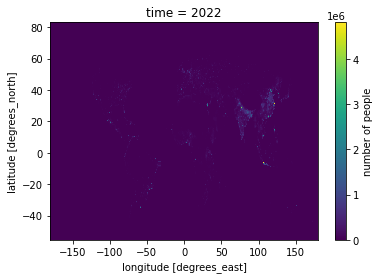

In [27]:

adult_startyear=40
gs_n_adults = gs_population_global.sel(ages=slice(adult_startyear,adult_startyear+18)).sum(dim='ages') 
gs_n_adults.plot()

Text(0.5, 1.0, 'number of adults x number of attributable hot days \nin 2020')

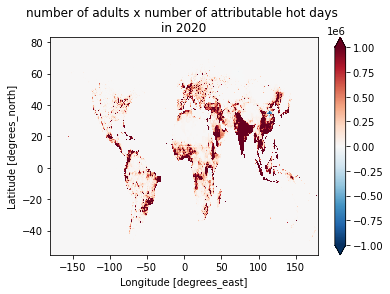

In [28]:
adults_hw_2022 = gs_n_adults * n_attr_2022
adults_hw_2022.plot(vmax=1e6)

plt.title('number of adults x number of attributable hot days \nin 2020')


In [29]:
(children_hw_2022 - adults_hw_2022).sum() # children x heatwaves are 1.7 bilion more than adults x heatwaves 

<xarray.DataArray ()>
array(1.61490662e+10)

In [30]:
adults_hw_2022.sum() # adults x heatwaves = 25 bilion (versus 42 bilion children)

<xarray.DataArray ()>
array(2.60946333e+10)

In [32]:
children_hw_2022.sum() / adults_hw_2022.sum() # children x hw is 1.6 times more than adults x heatwaves 

<xarray.DataArray ()>
array(1.61886542)

In [33]:
gs_n_adults.where(n_attr_2022>0).sum() 
# 1.5 bilion adults (versus 2.2 bilion children) live in places where heatwaves have increased - 
# more children than adults in places where hw increasing

<xarray.DataArray 'number of people' ()>
array(1.57623864e+09)

In [34]:
gs_n_adults.where(n_attr_2022>0).sum() / gs_n_adults.sum() # not included 

<xarray.DataArray 'number of people' ()>
array(0.96652848)

In [35]:
gs_n_adults.where(n_attr_2022<0).sum() # 54.6 mln adults (versus 53 milion children) live in places where heatwaves have decreased, according to this model - more adults than children in places where hw decresing (chceck this with model eval)

<xarray.DataArray 'number of people' ()>
array(54586186.45425508)

In [36]:
gs_n_adults.where(n_attr_2022>0).sum() / gs_n_adults.where(n_attr_2022<0).sum() 

# 28 times more adults (versus 41 times more kids) live in places where increase than decrease - more proportion of kids in places where increasing 

<xarray.DataArray 'number of people' ()>
array(28.87614513)

In [38]:
adults_hw_2022.where(adults_hw_2022>0).sum() / gs_n_adults.where(n_attr_2022>0).sum()

# adults x heatwaves / adults in those same grid cells 
# an average of 16 heatwaves per capita for adults (cfr. to children 19 heatwaves per capita) where the models show an increase 

<xarray.DataArray ()>
array(16.58727231)

## 3. Loop over models 

### to clean up

In [96]:
for GCM in GCMs:
    print(GCM)
    
    # TODO: sort out the getoutputpaths function its doing weird shit ! 
    datadir = f'/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_sep23-8523898/TX99/ISIMIP3b/{GCM}'

    # calculate number of attributable events at present-day warming level 
    p_pi = 1-0.99 # probability of ocurrence in pre-industrial 
    data_pi_99 = xr.open_dataarray( glob.glob(os.path.join(datadir,  '{}*1850_1900.nc'.format(GCM.lower())) )[0], engine='netcdf4')
    percentiles_pres_da = xr.open_dataarray(glob.glob(os.path.join(datadir, '{}*percentiles_pres_piTX99*.nc'.format(GCM.lower())))[0])
    p_pd = 1-percentiles_pres_da # probability of occurrence in the present-day
    
    # number of attributable events (days) = ndays * (p_pd - p_pi)    
    n_attr_2020 = 365 * (p_pd - p_pi)
    print(f'\ntotal number attributable hot days { n_attr_2020.where(n_attr_2020>0).sum().values / 10**6:.2f} million' )
    
    # combine with demographics
    # people x events
    children_hw_2020 = gs_n_children * n_attr_2020
    
    # print information
    # children
    children_times_heatwaves = children_hw_2020.where(children_hw_2020>0).sum().values
    children_times_heatwaves_decrease = children_hw_2020.where(children_hw_2020<0).sum().values
    children_where_attr_hw = gs_n_children.where(n_attr_2020>0).sum()
    children_where_attr_hw_decrease = gs_n_children.where(n_attr_2020<0).sum()
    children_per_capita_hw = children_hw_2020.where(children_hw_2020>0).sum() / gs_n_children.where(n_attr_2020>0).sum()
    
    total_n_children = gs_n_children.sum() # delete from loop
    
    print(f'\nin places where the model shows an increase in heatwaves, children x heatwaves = { children_times_heatwaves / 10**9:.2f} billion' )
    print(f'according to this model, where heatwaves are decreasing, decrease in children x heatwaves =  { children_times_heatwaves_decrease / 10**6:.2f} million' )
    print(f'children living in places where attributable heatwaves have occurred = { children_where_attr_hw / 10**9:.2f} billion')
    print(f'children living in places where heatwaves have decreased = { children_where_attr_hw_decrease / 10**6:.2f} million') 
    print(f'{ children_where_attr_hw / children_where_attr_hw_decrease :.1f} times more kids live in places where increase than decrease ' )  # check this
    print(f'total number of children = {total_n_children / 10**9:.2f} billion', f'of which {children_where_attr_hw / total_n_children * 100 :.2f}% in places with increase')
    print(f'average per capita heatwaves per child where the models show an increase = {children_per_capita_hw :.0f}  ')  # children x heatwaves / children in those same grid cells 

    # adults, 40-58 yo 
    adults_hw_2020 = gs_n_adults * n_attr_2020
    
    # store information
    adults_times_heatwaves = adults_hw_2020.where(adults_hw_2020>0).sum().values
    adults_times_heatwaves_decrease = adults_hw_2020.where(adults_hw_2020<0).sum().values
    adults_where_attr_hw = gs_n_adults.where(n_attr_2020>0).sum()
    adults_where_attr_hw_decrease =gs_n_adults.where(n_attr_2020<0).sum()
    adults_per_capita_hw =adults_hw_2020.where(adults_hw_2020>0).sum() / gs_n_adults.where(n_attr_2020>0).sum()
    
    total_n_adults = gs_n_adults.sum() # delete from loop
    
    # print info
    print(f'\nin places where the model shows an increase in heatwaves, adults x heatwaves = {adults_times_heatwaves/ 10**9:.2f} billion' )
    print(f'children x hw / adults x heatwaves = {children_times_heatwaves / adults_times_heatwaves :.2f} ') 
    
    print(f'adults living in places where attributable heatwaves have occurred = {adults_where_attr_hw / 10**9:.2f} billion') # more children than adults in places where hw increasing
    print(f'according to this model, where heatwaves are decreasing, decrease in adults x heatwaves =  { adults_times_heatwaves_decrease / 10**6:.2f} million' )
    print(f'adults living in places where heatwaves have decreased = { adults_where_attr_hw_decrease / 10**6:.2f} million') 
    print(f'{ adults_where_attr_hw / adults_where_attr_hw_decrease :.1f} times more adults live in places where increase than decrease ' )  # check this

    print(f'total number of adults = {total_n_adults / 10**9:.2f} billion', f'of which {adults_where_attr_hw / total_n_adults * 100 :.2f}% in places with increase')

    print(f'average per capita heatwaves per adult where the models show an increase = {adults_per_capita_hw :.0f}  ')  # children x heatwaves / children in those same grid cells 

    
#     # plots to check visually - move to a separate loop
    
#     # what temperature corresponds to TX99 in pre-industrial 
#     (data_pi_99-273.15).plot() 
#     plt.show()
    
#     # PR 
#     #(p_pd / p_pi).plot(cbar_kwargs={'label': 'PR TX99 present day vs. pi'}, cmap='RdBu_r',norm=colors.CenteredNorm()) # PR- - Probability ratio
#     #plt.show()
    
#     # number of attributable days in present-day warming level (check what year this is !)
#     n_attr_2020.plot(cbar_kwargs={'label': 'attributable days'})
#     plt.title('number of attributable hot days in 2020')
#     plt.show()
    
#     # children x heatwave
#     children_hw_2020.plot(vmax=1e6)
#     plt.title('number of children x number of attributable hot days \nin 2020')
#     plt.show()
    

CanESM5

total number attributable hot days 6.29 million

in places where the model shows an increase in heatwaves, children x heatwaves = 42.18 billion
according to this model, where heatwaves are decreasing, decrease in children x heatwaves =  -58.90 million
children living in places where attributable heatwaves have occurred = 2.21 billion
children living in places where heatwaves have decreased = 53.61 million
41.2 times more kids live in places where increase than decrease 
total number of children = 2.26 billion of which 97.63% in places with increase
average per capita heatwaves per child where the models show an increase = 19  

in places where the model shows an increase in heatwaves, adults x heatwaves = 25.23 billion
children x hw / adults x heatwaves = 1.67 
adults living in places where attributable heatwaves have occurred = 1.54 billion
according to this model, where heatwaves are decreasing, decrease in adults x heatwaves =  -50.66 million
adults living in places where h

CanESM5

total number attributable hot days 6.29 million


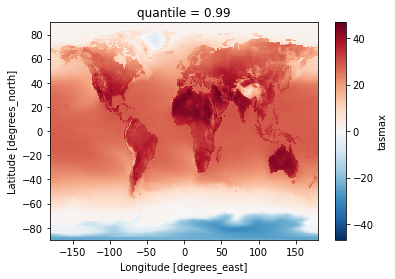

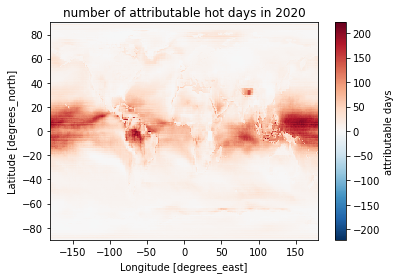

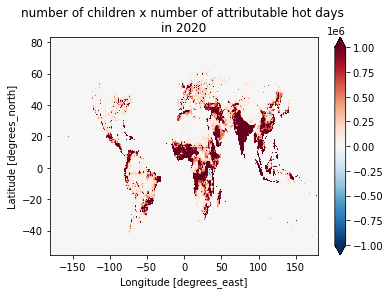

CNRM-CM6-1

total number attributable hot days 7.00 million


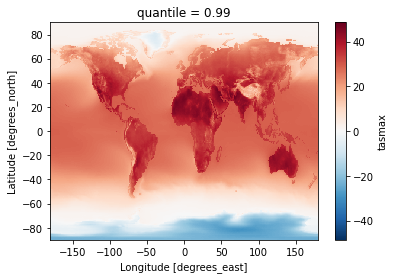

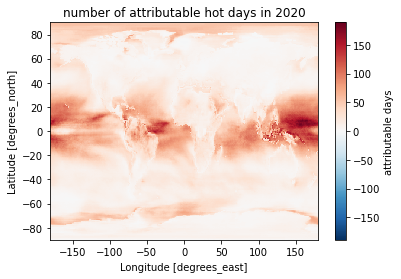

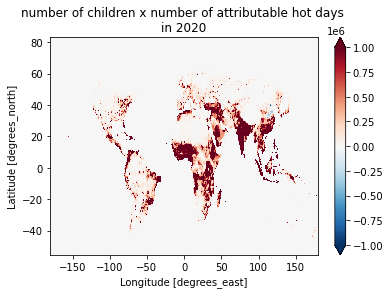

GFDL-ESM4

total number attributable hot days 8.37 million


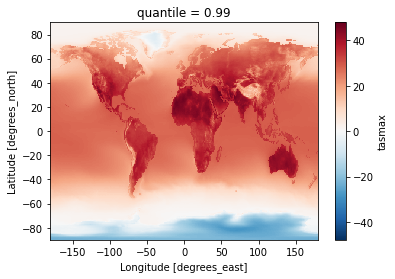

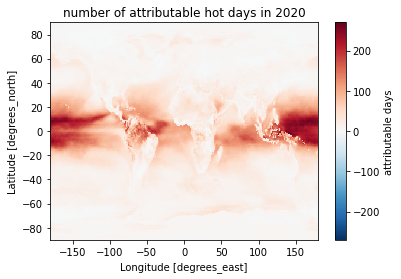

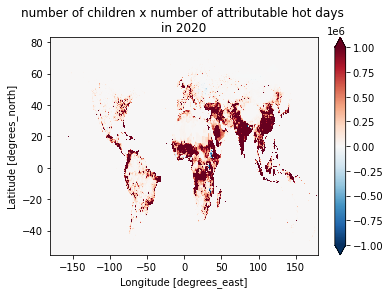

IPSL-CM6A-LR

total number attributable hot days 6.67 million


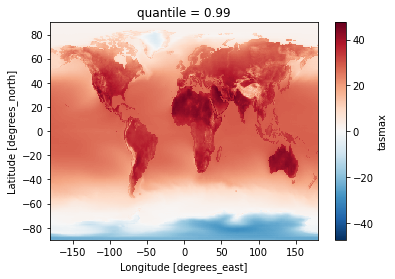

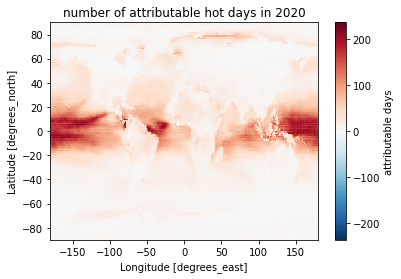

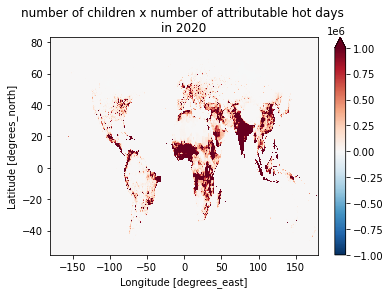

MIROC6

total number attributable hot days 6.25 million


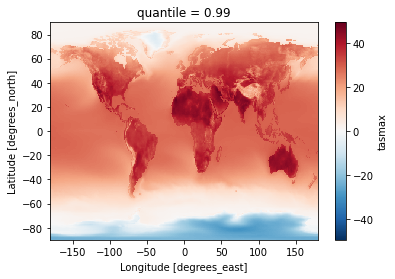

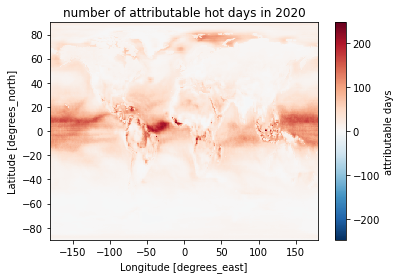

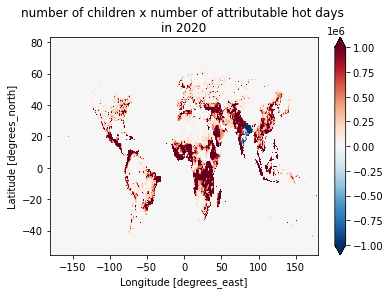

MRI-ESM2-0

total number attributable hot days 5.08 million


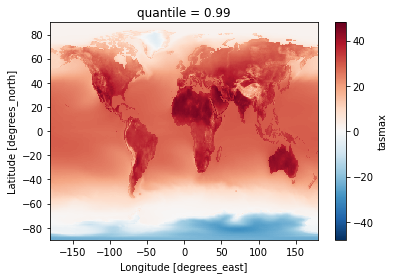

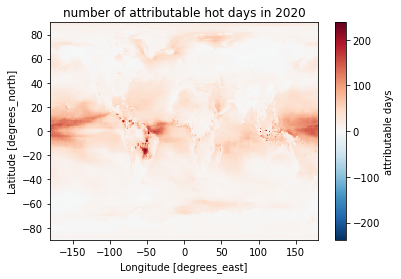

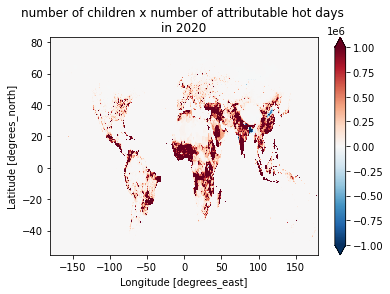

In [95]:
for GCM in GCMs:
    print(GCM)
    
    # TODO: sort out the getoutputpaths function its doing weird shit ! 
    datadir = f'/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_sep23-8523898/TX99/ISIMIP3b/{GCM}'

    # calculate number of attributable events at present-day warming level 
    p_pi = 1-0.99 # probability of ocurrence in pre-industrial 
    data_pi_99 = xr.open_dataarray( glob.glob(os.path.join(datadir,  '{}*1850_1900.nc'.format(GCM.lower())) )[0], engine='netcdf4')
    percentiles_pres_da = xr.open_dataarray(glob.glob(os.path.join(datadir, '{}*percentiles_pres_piTX99*.nc'.format(GCM.lower())))[0])
    p_pd = 1-percentiles_pres_da # probability of occurrence in the present-day
    
    # number of attributable events (days) = ndays * (p_pd - p_pi)    
    n_attr_2020 = 365 * (p_pd - p_pi)
    print(f'\ntotal number attributable hot days { n_attr_2020.where(n_attr_2020>0).sum().values / 10**6:.2f} million' )
    
    # combine with demographics
    # people x events
    children_hw_2020 = gs_n_children * n_attr_2020
    
    # print information
    # children
    children_times_heatwaves = children_hw_2020.where(children_hw_2020>0).sum().values
    children_times_heatwaves_decrease = children_hw_2020.where(children_hw_2020<0).sum().values
    children_where_attr_hw = gs_n_children.where(n_attr_2020>0).sum()
    children_where_attr_hw_decrease = gs_n_children.where(n_attr_2020<0).sum()
    children_per_capita_hw = children_hw_2020.where(children_hw_2020>0).sum() / gs_n_children.where(n_attr_2020>0).sum()
    
    total_n_children = gs_n_children.sum() # delete from loop
    
    # print(f'\nin places where the model shows an increase in heatwaves, children x heatwaves = { children_times_heatwaves / 10**9:.2f} billion' )
    # print(f'according to this model, where heatwaves are decreasing, decrease in children x heatwaves =  { children_times_heatwaves_decrease / 10**6:.2f} million' )
    # print(f'children living in places where attributable heatwaves have occurred = { children_where_attr_hw / 10**9:.2f} billion')
    # print(f'children living in places where heatwaves have decreased = { children_where_attr_hw_decrease / 10**6:.2f} million') 
    # print(f'{ children_where_attr_hw / children_where_attr_hw_decrease :.1f} times more kids live in places where increase than decrease ' )  # check this
    # print(f'total number of children = {total_n_children / 10**9:.2f} billion', f'of which {children_where_attr_hw / total_n_children * 100 :.2f}% in places with increase')
    # print(f'average per capita heatwaves per child where the models show an increase = {children_per_capita_hw :.0f}  ')  # children x heatwaves / children in those same grid cells 

    # adults, 40-58 yo 
    adults_hw_2020 = gs_n_adults * n_attr_2020
    
    # store information
    adults_times_heatwaves = adults_hw_2020.where(adults_hw_2020>0).sum().values
    adults_times_heatwaves_decrease = adults_hw_2020.where(adults_hw_2020<0).sum().values
    adults_where_attr_hw = gs_n_adults.where(n_attr_2020>0).sum()
    adults_where_attr_hw_decrease =gs_n_adults.where(n_attr_2020<0).sum()
    adults_per_capita_hw =adults_hw_2020.where(adults_hw_2020>0).sum() / gs_n_adults.where(n_attr_2020>0).sum()
    
    total_n_adults = gs_n_adults.sum() # delete from loop
    
#     # print info
#     print(f'\nin places where the model shows an increase in heatwaves, adults x heatwaves = {adults_times_heatwaves/ 10**9:.2f} billion' )
#     print(f'children x hw / adults x heatwaves = {children_times_heatwaves / adults_times_heatwaves :.2f} ') 
#     print(f'adults living in places where attributable heatwaves have occurred = {adults_where_attr_hw / 10**9:.2f} billion') # more children than adults in places where hw increasing
#     print(f'according to this model, where heatwaves are decreasing, decrease in adults x heatwaves =  { adults_times_heatwaves_decrease / 10**6:.2f} million' )
#     print(f'adults living in places where heatwaves have decreased = { adults_where_attr_hw_decrease / 10**6:.2f} million') 
#     print(f'{ adults_where_attr_hw / adults_where_attr_hw_decrease :.1f} times more adults live in places where increase than decrease ' )  # check this
#     print(f'total number of adults = {total_n_adults / 10**9:.2f} billion', f'of which {adults_where_attr_hw / total_n_adults * 100 :.2f}% in places with increase')
#     print(f'average per capita heatwaves per adult where the models show an increase = {adults_per_capita_hw :.0f}  ')  # children x heatwaves / children in those same grid cells 

    
    # plots to check visually - move to a separate loop
    
    # what temperature corresponds to TX99 in pre-industrial 
    (data_pi_99-273.15).plot() 
    plt.show()
    
    # PR 
    #(p_pd / p_pi).plot(cbar_kwargs={'label': 'PR TX99 present day vs. pi'}, cmap='RdBu_r',norm=colors.CenteredNorm()) # PR- - Probability ratio
    #plt.show()
    
    # number of attributable days in present-day warming level (check what year this is !)
    n_attr_2020.plot(cbar_kwargs={'label': 'attributable days'})
    plt.title('number of attributable hot days in 2020')
    plt.show()
    
    # children x heatwave
    children_hw_2020.plot(vmax=1e6)
    plt.title('number of children x number of attributable hot days \nin 2020')
    plt.show()
    
total_n_children = gs_n_children.sum()

[6.29, 7.0, 8.37, 6.67, 6.25, 5.08]

## make a function

In [39]:
def calculate_attr_hw_adults_children(GCMs, gs_n_children, gs_n_adults): # list, da, da - maybe rename ? 
    
    # TODO: change '2020' to 'year'
    
    cols = ['tot_n_hw','child_hw', 'child_hw_decr', 'child_whr_increase', 'child_whr_decrease', 'child_hw_pc',
                                     'adult_hw', 'adult_hw_decr', 'adult_whr_increase', 'adult_whr_decrease', 'adult_hw_pc']
    
    df = pd.DataFrame(columns=cols)
    
    for GCM in GCMs:
    
        datadir = f'/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_sep23-8523898/TX99/ISIMIP3b/{GCM}'

        # calculate number of attributable events at present-day warming level 
        p_pi = 1-0.99 # probability of ocurrence in pre-industrial 
        data_pi_99 = xr.open_dataarray( glob.glob(os.path.join(datadir,  '{}*1850_1900.nc'.format(GCM.lower())) )[0], engine='netcdf4') # not necessary here, delete?
        percentiles_pres_da = xr.open_dataarray(glob.glob(os.path.join(datadir, '{}*percentiles_pres_piTX99*.nc'.format(GCM.lower())))[0])
        p_pd = 1-percentiles_pres_da # probability of occurrence in the present-day

        # number of attributable events (days) = ndays * (p_pd - p_pi)    
        n_attr_2020 = 365 * (p_pd - p_pi)
        total_n_attr = n_attr_2020.where(n_attr_2020>0).sum().values

        # combine with demographics
        # people x events
        children_hw_2020 = gs_n_children * n_attr_2020

        # adults, 40-58 yo 
        adults_hw_2020 = gs_n_adults * n_attr_2020

        # information children
        children_times_heatwaves = children_hw_2020.where(children_hw_2020>0).sum().values
        children_times_heatwaves_decrease = children_hw_2020.where(children_hw_2020<0).sum().values
        children_where_attr_hw = gs_n_children.where(n_attr_2020>0).sum().values
        children_where_attr_hw_decrease = gs_n_children.where(n_attr_2020<0).sum().values
        children_per_capita_hw = children_hw_2020.where(children_hw_2020>0).sum().values / gs_n_children.where(n_attr_2020>0).sum().values

        # information adults
        adults_times_heatwaves = adults_hw_2020.where(adults_hw_2020>0).sum().values
        adults_times_heatwaves_decrease = adults_hw_2020.where(adults_hw_2020<0).sum().values
        adults_where_attr_hw = gs_n_adults.where(n_attr_2020>0).sum().values
        adults_where_attr_hw_decrease =gs_n_adults.where(n_attr_2020<0).sum().values
        adults_per_capita_hw =adults_hw_2020.where(adults_hw_2020>0).sum().values / gs_n_adults.where(n_attr_2020>0).sum().values

        # put all in a df
        data = [[ float(ele) for ele in [total_n_attr, children_times_heatwaves,children_times_heatwaves_decrease, children_where_attr_hw, 
                children_where_attr_hw_decrease, children_per_capita_hw,
                adults_times_heatwaves, adults_times_heatwaves_decrease, adults_where_attr_hw, adults_where_attr_hw_decrease, adults_per_capita_hw ]]]

        df_mod = pd.DataFrame(data=data, columns=cols)

        # concat all the model dfs
        df = pd.concat([df, df_mod], axis=0, ignore_index=True)
    
    df.insert(loc=0, column='model', value=GCMs)
    df = df.set_index('model')
    
    return df

In [40]:
df = calculate_attr_hw_adults_children(GCMs, gs_n_children, gs_n_adults)
pd.options.display.float_format = '{:.2e}'.format
df

,tot_n_hw,child_hw,child_hw_decr,child_whr_increase,child_whr_decrease,child_hw_pc,adult_hw,adult_hw_decr,adult_whr_increase,adult_whr_decrease,adult_hw_pc
model,,,,,,,,,,,
CanESM5,6.29e+06,4.23e+10,-5.92e+07,2.21e+09,5.35e+07,1.91e+01,2.61e+10,-5.09e+07,1.58e+09,5.46e+07,1.66e+01
CNRM-CM6-1,7.00e+06,3.09e+10,-2.33e+07,2.21e+09,5.13e+07,1.39e+01,1.83e+10,-3.19e+07,1.56e+09,6.89e+07,1.17e+01
GFDL-ESM4,8.37e+06,3.26e+10,-1.92e+08,2.15e+09,1.18e+08,1.52e+01,2.17e+10,-7.48e+07,1.57e+09,6.06e+07,1.38e+01
IPSL-CM6A-LR,6.67e+06,3.02e+10,-6.49e+05,2.26e+09,1.76e+06,1.34e+01,1.78e+10,-7.60e+05,1.63e+09,2.06e+06,1.09e+01
MIROC6,6.25e+06,4.24e+10,-6.84e+08,2.01e+09,2.58e+08,2.11e+01,2.31e+10,-4.39e+08,1.47e+09,1.65e+08,1.58e+01
MRI-ESM2-0,5.08e+06,3.14e+10,-2.42e+08,2.11e+09,1.56e+08,1.49e+01,1.89e+10,-1.91e+08,1.50e+09,1.31e+08,1.26e+01


In [264]:
def format_large_numbers(x):
    try:
        x = float(x)
        if abs(x) >= 1e9:
            return f'{x/1e9:.1f}B'
        if abs(x) >= 1e6:
            return f'{x/1e6:.1f}M'
        if abs(x) >= 1e3:
            return f'{x/1e3:.1f}K'
        if abs(x) <= 1e2:
            return f'{x:.1f}'
        return str(x)
    except ValueError:
        return x

df.applymap(format_large_numbers)

,tot_n_hw,child_hw,child_hw_decr,child_whr_increase,child_whr_decrease,child_hw_pc,adult_hw,adult_hw_decr,adult_whr_increase,adult_whr_decrease,adult_hw_pc
model,,,,,,,,,,,
CanESM5,6.3M,42.2B,-58.9M,2.2B,53.6M,19.1,25.2B,-50.7M,1.5B,54.6M,16.4
CNRM-CM6-1,7.0M,30.7B,-23.6M,2.2B,52.1M,13.9,17.7B,-32.1M,1.5B,69.4M,11.6
GFDL-ESM4,8.4M,32.5B,-188.2M,2.1B,116.6M,15.1,21.1B,-70.7M,1.5B,58.2M,13.8
IPSL-CM6A-LR,6.7M,30.0B,-647.2K,2.3B,1.8M,13.3,17.1B,-751.9K,1.6B,2.0M,10.8
MIROC6,6.2M,42.1B,-690.8M,2.0B,260.1M,21.0,22.2B,-418.2M,1.4B,157.9M,15.5
MRI-ESM2-0,5.1M,31.2B,-244.7M,2.1B,157.7M,14.8,18.2B,-186.0M,1.5B,128.3M,12.4


In [41]:
def format_large_numbers(x):
    try:
        x = float(x)
        if abs(x) >= 1e9:
            return f'{x/1e9:.1f}B'
        if abs(x) >= 1e6:
            return f'{x/1e6:.1f}M'
        if abs(x) >= 1e3:
            return f'{x/1e3:.1f}K'
        if abs(x) <= 1e2:
            return f'{x:.1f}'
        return str(x)
    except ValueError:
        return x

df.applymap(format_large_numbers)

# updated version - check why difference with otehr scirpt ! 

,tot_n_hw,child_hw,child_hw_decr,child_whr_increase,child_whr_decrease,child_hw_pc,adult_hw,adult_hw_decr,adult_whr_increase,adult_whr_decrease,adult_hw_pc
model,,,,,,,,,,,
CanESM5,6.3M,42.3B,-59.2M,2.2B,53.5M,19.1,26.1B,-50.9M,1.6B,54.6M,16.6
CNRM-CM6-1,7.0M,30.9B,-23.3M,2.2B,51.3M,13.9,18.3B,-31.9M,1.6B,68.9M,11.7
GFDL-ESM4,8.4M,32.6B,-192.0M,2.1B,118.2M,15.2,21.7B,-74.8M,1.6B,60.6M,13.8
IPSL-CM6A-LR,6.7M,30.2B,-649.1K,2.3B,1.8M,13.4,17.8B,-759.8K,1.6B,2.1M,10.9
MIROC6,6.2M,42.4B,-683.9M,2.0B,257.7M,21.1,23.1B,-438.6M,1.5B,165.5M,15.8
MRI-ESM2-0,5.1M,31.4B,-241.5M,2.1B,155.7M,14.9,18.9B,-191.3M,1.5B,131.1M,12.6


In [42]:
# multi-model median

df.median().apply(format_large_numbers)

tot_n_hw                 6.5M
child_hw                32.0B
child_hw_decr         -125.6M
child_whr_increase       2.2B
child_whr_decrease      85.9M
child_hw_pc              15.0
adult_hw                20.3B
adult_hw_decr          -62.8M
adult_whr_increase       1.6B
adult_whr_decrease      64.8M
adult_hw_pc              13.2
dtype: object

In [43]:
# multi-model mean

df.mean().apply(format_large_numbers)

tot_n_hw                 6.6M
child_hw                35.0B
child_hw_decr         -200.1M
child_whr_increase       2.2B
child_whr_decrease     106.4M
child_hw_pc              16.3
adult_hw                21.0B
adult_hw_decr         -131.4M
adult_whr_increase       1.6B
adult_whr_decrease      80.5M
adult_hw_pc              13.6
dtype: object

Text(0.5, 1.0, 'person x heatwave days')

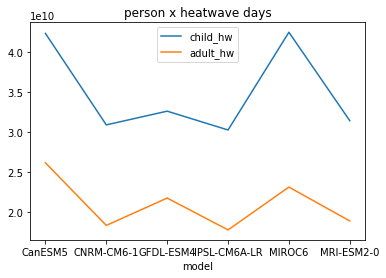

In [44]:
df[['child_hw','adult_hw']].plot()
plt.title('person x heatwave days')

Text(0.5, 1.0, 'per capita heatwave days')

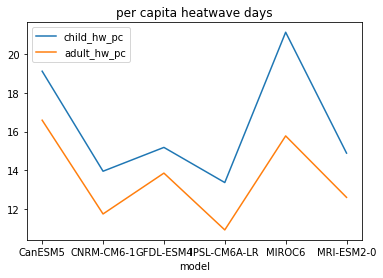

In [45]:
df[['child_hw_pc','adult_hw_pc']].plot()
plt.title('per capita heatwave days')

Text(0.5, 1.0, 'number of people where attributable heatwaves')

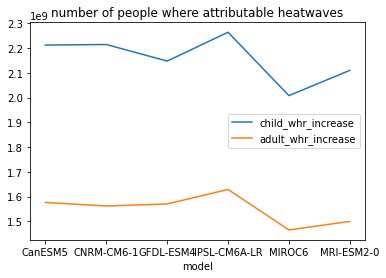

In [46]:
df[['child_whr_increase','adult_whr_increase']].plot()
plt.title('number of people where attributable heatwaves')

Text(0.5, 1.0, 'person x decrease in heatwave days')

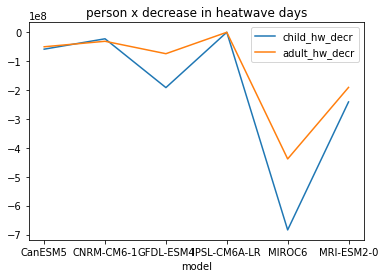

In [47]:
df[['child_hw_decr','adult_hw_decr']].plot()
plt.title('person x decrease in heatwave days')

Text(0.5, 1.0, 'number of people where attributable heatwaves decrease')

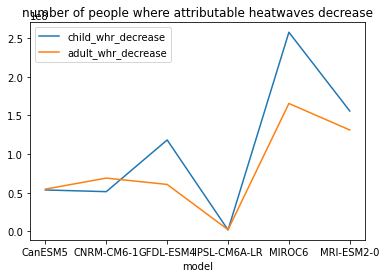

In [48]:
df[['child_whr_decrease','adult_whr_decrease']].plot()
plt.title('number of people where attributable heatwaves decrease')